In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.ticker import MultipleLocator

# Parameters
folder = 'f15000'
file_pattern = os.path.join(folder, 'data*.lvm')

# Load all data files and concatenate into a single array
all_data = []
file_list = sorted(glob.glob(file_pattern))
print(file_list)
for fname in file_list:
    data = np.loadtxt(fname, skiprows=22)
    velocities = data[:, 1].astype(float)
    all_data.append(velocities)
all_data = np.concatenate(all_data)
total_mean = np.mean(all_data)
total_var = np.var(all_data)

print(f"Mean: {total_mean}, Variance: {total_var}")

['f15000/data0.lvm', 'f15000/data1.lvm', 'f15000/data10.lvm', 'f15000/data2.lvm', 'f15000/data3.lvm', 'f15000/data4.lvm', 'f15000/data5.lvm', 'f15000/data6.lvm', 'f15000/data7.lvm', 'f15000/data8.lvm', 'f15000/data9.lvm']
Mean: 11.019209904779082, Variance: 2.8424743284194345


In [8]:
# Autocorrelation functions
def compute_autocorr(x, mean, var, max_lag=None):
    N = len(x)
    if max_lag is None:
        max_lag = N - 1
    acorr = np.zeros(max_lag+1)
    for lag in range(max_lag+1):
        if lag == 0:
            acorr[lag] = 1.0
        else:
            num = np.sum((x[:N-lag] - mean) * (x[lag:] - mean))
            denom = N * (var ** 2)
            acorr[lag] = num / denom
    return acorr

def ensemble_autocorr(records, use_global_stats=False, global_mean=None, global_var=None):
    acorrs = []
    for rec in records:
        if use_global_stats:
            mean = global_mean
            var = global_var
        else:
            mean = np.mean(rec)
            var = np.var(rec)
            #print(f"Record mean: {mean}, Record variance: {var}")
        acorrs.append(compute_autocorr(rec, mean, var))
    return np.mean(acorrs, axis=0)

def compute_2Tu(acorr):
    # 2Tu = 1 + 2 * sum_{k=0}^{inf} rho(k) * dt, here dt=1
    # We'll sum until autocorr drops below 0
    #positive_rho = acorr[acorr > 0]
    #return 1 + 2 * np.sum(positive_rho)
    return 1 + 2 * np.sum(acorr)


In [9]:
results = {}
record_sizes = [500, 1000, 5000, 10000]

for rec_size in record_sizes:
    # Split all files into records of rec_size
    records = []
    for fname in file_list:
        data = np.loadtxt(fname, skiprows=22)
        velocities = data[:, 1].astype(float)
        n_records = len(velocities) // rec_size
        for i in range(n_records):
            rec = velocities[i*rec_size:(i+1)*rec_size]
            if len(rec) == rec_size:
                records.append(rec)

    # Per-record stats
    acorr_per_record = ensemble_autocorr(records, use_global_stats=False)
    Tu_per_record = compute_2Tu(acorr_per_record)
    
    # Global stats
    acorr_global = ensemble_autocorr(records, use_global_stats=True, global_mean=total_mean, global_var=total_var)
    Tu_global = compute_2Tu(acorr_global)
    results[rec_size] = {
        'per_record': (acorr_per_record, Tu_per_record),
        'global': (acorr_global, Tu_global)
    }

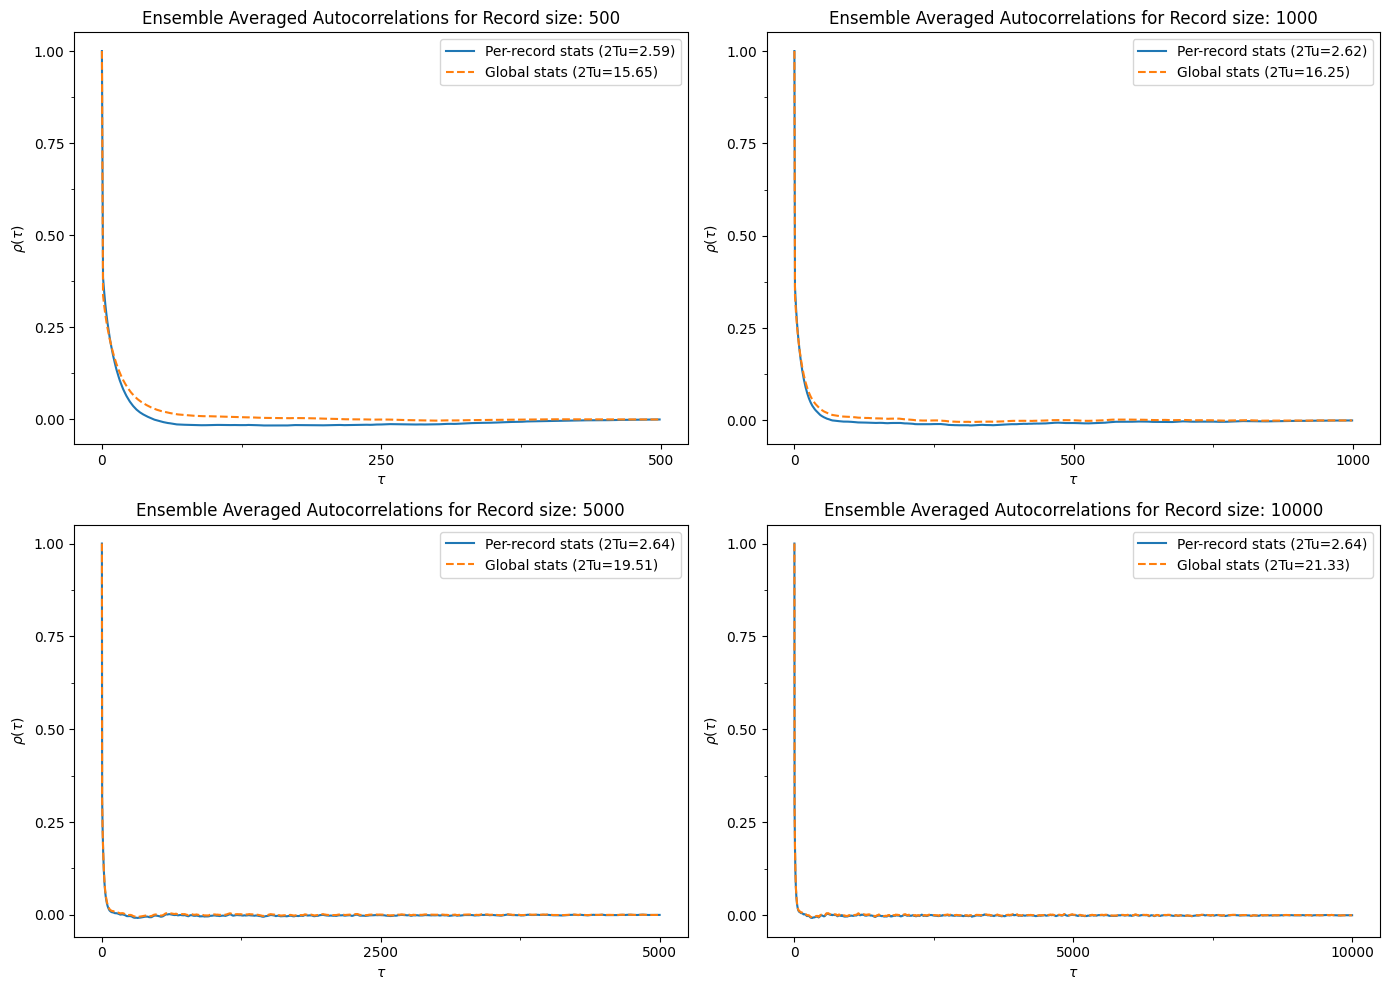

In [10]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for idx, rec_size in enumerate(record_sizes):
    ax = axes[idx]
    acorr_per_record, Tu_per_record = results[rec_size]['per_record']
    acorr_global, Tu_global = results[rec_size]['global']
    lags = np.arange(len(acorr_per_record))
    ax.plot(lags, acorr_per_record, label=f'Per-record stats (2Tu={Tu_per_record:.2f})')
    ax.plot(lags, acorr_global, label=f'Global stats (2Tu={Tu_global:.2f})', linestyle='--')
    ax.set_title(f'Ensemble Averaged Autocorrelations for Record size: {rec_size}')
    ax.set_xlabel('$\\tau$')  # Greek letter tau
    ax.set_ylabel('$\\rho(\\tau)$')  # Greek letter rho with tau
    ax.legend()
    ax.yaxis.set_major_locator(MultipleLocator(0.25))  # Major ticks every 0.25
    ax.yaxis.set_minor_locator(MultipleLocator(0.125))  # Minor ticks every 0.125
    ax.xaxis.set_major_locator(MultipleLocator(rec_size/2))
    ax.xaxis.set_minor_locator(MultipleLocator(rec_size/4))
plt.tight_layout()
plt.show()